<a href="https://colab.research.google.com/github/mmcenta/default-prediction/blob/master/default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install prince
!pip install seaborn

# Credit Default Prediction

*Students: Leonardo CUNHA and Matheus CENTA*

This notebook explores a credit default prediction dataset, which is notably imbalanced (the number of instances were there was a default is much smaller than the instances with no default). First, we load the necessary libraries.

In [0]:
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from prince import MFA, MCA
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Preprocessing

First, we define our preprocessing pipeline. The features are separated into three types: categoricals, numerical and dates. When using [Multi Factor Analysis](https://personal.utdallas.edu/~herve/Abdi-MFA2007-pretty.pdf) (MCA), first a Principal Component Analysis (PCA) or a Multi Correspondence Analysis (MCA) is fitted to each group and then a PCA is fitted to the resulting features.

A novel feature of whether the account was closed can be added via the keyword argument `include_closed`.



In [0]:
def apply_dimensionality_reduction(
    X,
    n_components,
    method='MFA',
    groups={},
  ):
  '''
  Applies a dimensionality reduction method to an input X.

  Args:
    X: (pandas.DataFrame) the input matrix.
    n_components: (int) dimensionality of latent space, the number of components
      of X that are obtained after transform.
    method: (str) the dimensionality reduction method to use (PCA or MFA).
    groups: (dict) a dict mapping the group names to the column names for MFA.
  
  Returns:
    The reduced form of the matrix X with n_components columns.
  '''
  if method == 'PCA':
    transf = PCA(n_components=n_components)
  elif method == 'MFA':
    transf = MFA(groups=groups, n_components=n_components, n_iter=1000)
  else:
    raise ValueError('Invalid dimensionality reduction method {:}.'.format(method))
  return transf.fit_transform(X)

 
def preprocess_data(
    raw_data,
    reduction=None,
    n_components=10,
    include_closed=True,
    shuffle=False,
    return_df=False
  ):
  '''
  Transforms the raw CSV data into a matrix X of features and a vector Y of
  labels.

  Args:
    raw_data: (pandas.DataFrama) the raw CSV data.
    reduction: (str) the dimensionality reduction method to use.
    n_components: (int) dimensionality of latent space, the number of components
      of X that are obtained after transform.
    include_closed: (bool) whether to include a boolean feature based on the
      'Prod_Closed_Date' column.
    shuffle: (bool) whether to randomly shuffle the data.

  Returns:
    (X, Y), a tuple containing the preprocessed features and the labels.
  '''
  N = raw_data.shape[0]
  Y = raw_data['Y']
  X = raw_data.drop(columns=['Id_Customer', 'Y'])
 
  # select categorical features
  categoricals = X[['Customer_Type', 'P_Client',
                    'Educational_Level', 'Marital_Status',
                    'Prod_Sub_Category', 'Source',
                    'Type_Of_Residence', 'Prod_Category']]

  if include_closed:
    # this feature is 1 when the account was already closed
    closed = X['Prod_Closed_Date'].notnull().astype(str)
    categoricals = pd.concat([categoricals, closed], axis=1)
  
  # select numerical features
  X['Net_Annual_Income'] = X['Net_Annual_Income'].astype(str).apply(
      lambda x: x.replace(',','.')).astype(float) # convert to float

  numericals = X[['Number_Of_Dependant','Years_At_Residence',
                  'Net_Annual_Income', 'Years_At_Business','Nb_Of_Products']]

  numericals = (numericals - numericals.mean()) / numericals.std() # normalize
  numericals = numericals.fillna(numericals.mean()) # fill nan with column mean
 
  # select datetype features
  dates = pd.to_datetime(X[['BirthDate','Customer_Open_Date',
                             'Prod_Decision_Date']].stack()).unstack()
  dates = (dates - dates.min(axis=0)) / np.timedelta64(1,'D')

  # concatenate all types of data
  if reduction == 'MFA':
    X = pd.concat([numericals, dates, categoricals], axis=1)
    groups = {
        'categoricals': categoricals.columns,
        'dates': dates.columns,
        'categoricals': categoricals.columns,
    }
    X = apply_dimensionality_reduction(X, n_components, method=reduction,
                                       groups=groups)
  else:
    categoricals = pd.get_dummies(categoricals).astype(int)
    X = pd.concat([numericals, dates, categoricals], axis=1)
    if reduction == 'PCA':
      X = apply_dimensionality_reduction(X, n_components, method=reduction)


  if return_df:
      return X, Y

  if isinstance(X, pd.DataFrame) :
    X, Y = X.values, Y.values
  if shuffle:
    new_indices = np.random.permutation(N)
    X = X[new_indices]
    Y = Y[new_indices]
    
  return np.squeeze(X), np.squeeze(Y)


Now we load and preprocess the data. We construct three datasets: one using PCA as dimensionality reduction, one using MFA instead and one with full dimensions. 

In [0]:
raw_data = pd.read_csv('./CreditTraining.csv')
X_full, Y_full = preprocess_data(raw_data)
X_mfa, Y_mfa = preprocess_data(raw_data, reduction='MFA', n_components=20)
X_pca, Y_pca = preprocess_data(raw_data, reduction='PCA', n_components=20)

Let's visualize the first two components of the datasets with reduced dimensions.

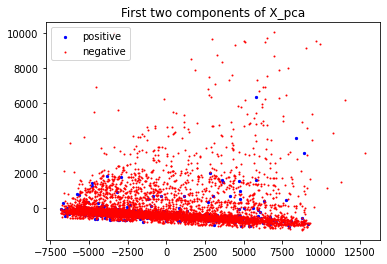

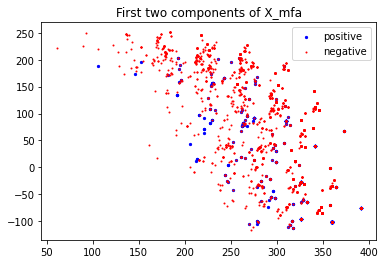

In [0]:
def visualize_embedded(X_emb, Y, title=None):
  positive = np.array([X_emb[i] for i in range(len(Y)) if Y[i] == 1])
  negative = np.array([X_emb[i] for i in range(len(Y)) if Y[i] == 0])

  plt.scatter(positive[:,0], positive[:,1], c='b', s=5, label='positive')
  plt.scatter(negative[:,0], negative[:,1], c='r', s=1, label='negative')
  plt.legend()
  if title is not None:
    plt.title(title)
  plt.show()

visualize_embedded(X_pca, Y_pca, title='First two components of X_pca')
visualize_embedded(X_mfa, Y_mfa, title='First two components of X_mfa')

## Data Exploration

First, let's take a look at our data to understand it better.

In [0]:
raw_data.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36,1.0,C,14/02/2012,Sales,Owned,1,NaN,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18,2.0,C,30/06/2011,Sales,Parents,1,NaN,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36,1.0,C,04/04/2012,Sales,Owned,1,NaN,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36,1.0,C,07/09/2011,Sales,New rent,1,31/12/2012,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36,1.0,C,11/01/2012,Sales,Owned,1,NaN,D


Here we see that the features can be categories, numbers or dates, and that there are missing values.

First, let's see which columns contain missing values and how many of them there are.

In [0]:
raw_data.isnull().sum()

Id_Customer               0
Y                         0
Customer_Type             0
BirthDate                 0
Customer_Open_Date        0
P_Client                  0
Educational_Level         0
Marital_Status            0
Number_Of_Dependant       2
Years_At_Residence        0
Net_Annual_Income         2
Years_At_Business         2
Prod_Sub_Category         0
Prod_Decision_Date        0
Source                    0
Type_Of_Residence         0
Nb_Of_Products            0
Prod_Closed_Date       4206
Prod_Category             0
dtype: int64

Here we see that most clients on the dataset are missing the product closing date, which we will deal with later. Note that all other missing values are numerical, which is why we opted to fill the missing values with the mean of column it belongs to.

Below, we'll do a plot of the distribution of each class regarding each variable, red corresponding to the clients who have defaulted and blue to those who did not. Remember that the  dates are in a scale of days regarding the first date that appeared in that column

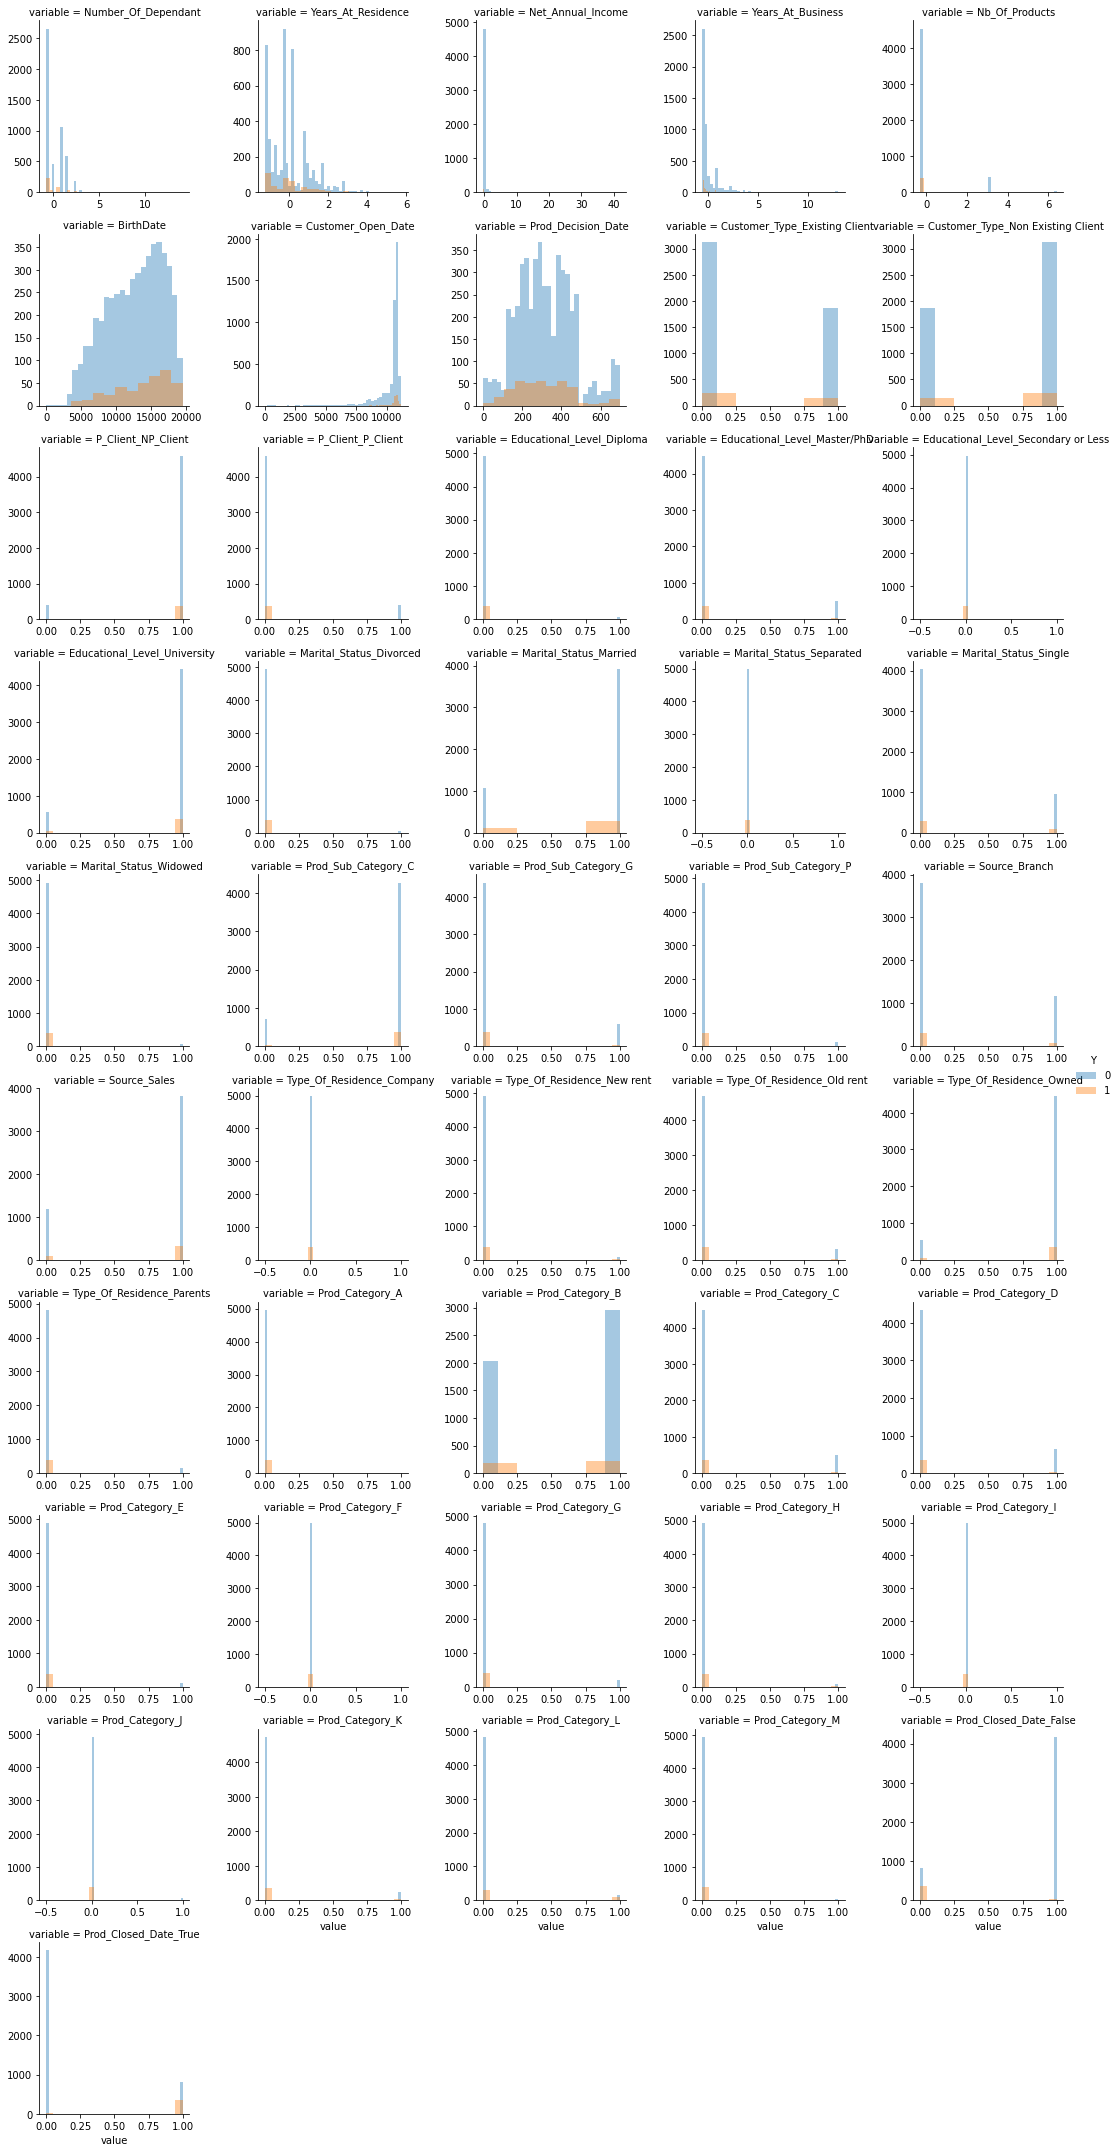

In [0]:
X_df, Y_df = preprocess_data(raw_data, return_df=True)
data = pd.concat([X_df, Y_df], axis=1)
f = pd.melt(data, id_vars='Y', value_vars=X_df.columns)
g = sns.FacetGrid(f, hue='Y', col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map(sns.distplot, "value", kde=False).add_legend()

It's curious that there are several variables where the clients who've defaulted seem to be perfectly split, i.e., none of them are separated, divorced, or have net annual income above 0. This suggests that these variables are highly useful for eliminating possible postive predictions

Next, we will analyse the class imbalance in our data.

In [0]:
default_proportion = (raw_data['Y'].sum() / len(raw_data))
print('{:.2f}% of clients defaulted.'.format(default_proportion * 100))

7.30% of clients defaulted.


In [0]:
closed = (raw_data['Prod_Closed_Date'].notnull())
closed_default_proportion = raw_data[closed]['Y'].sum() / closed.sum()
print("{:.2f}% of clients with closed products defaulted.".format(
    closed_default_proportion * 100))

30.66% of clients with closed products defaulted.


Here we can see that the proportion of defaults for clients with closed accounts around four times bigger than the overall default proportion. This motivates leveraging this feature, even though its valus is missing for most clients.

### Visualization with t-SNE

Now we are going to visualize the dataset with the t-SNE method. First we visualize the full dataset, without dimensionality reduction.

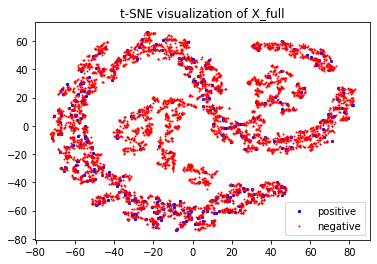

In [0]:
from sklearn.manifold import TSNE

X_full_vis = TSNE(n_components=2).fit_transform(X_full)
visualize_embedded(X_full_vis, Y_full, title='t-SNE visualization of X_full')

We can see that the classes not only overlap, but present similar structure. This indicates that achieving high performance will be difficult with this data.

We generate the same visualization for the dataset with reduced dimension.

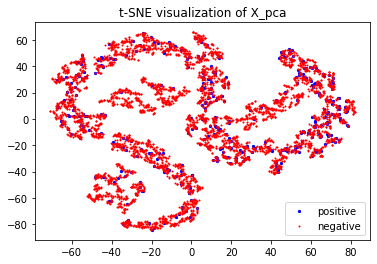

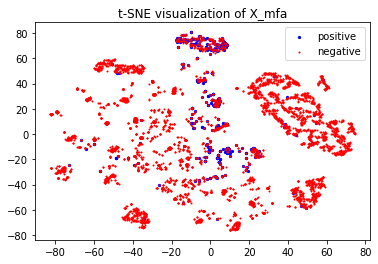

In [0]:
X_pca_vis = TSNE(n_components=2).fit_transform(X_pca)
X_mfa_vis = TSNE(n_components=2).fit_transform(X_mfa)
visualize_embedded(X_pca_vis, Y_pca, title='t-SNE visualization of X_pca')
visualize_embedded(X_mfa_vis, Y_mfa, title='t-SNE visualization of X_mfa')

The PCA visualization is very similar to the visualization for the full dataset. While there is overlap, the MFA was able to concentrate positive examples in such a way that the structure of both classes is now different.

## Prediction

Before training models and performing hyperparameter tuning, it is necessary to define the loss functtion and the performance metric for this problem.

### Loss Function

We use weights to deal with the strong class imbalance in the data, instead of recurring to techniques such as undersampling or oversampling. For all our trained predictors, the class weights are such that

$$\pi_0 C_0 = \pi_1 C_1,$$

where $\pi_i$ is the estimated probability of the class $i$ in the data and $C_i$ is the weight for class $i$.

We also considered using weights proportional to the estimated monetary loss for each class so that the loss function reflects the objective of the company providing the credit products. However, given that no data was given regarding the values and fees of these products, we are unable to estimate theses quantities. Ultimately, we opted to use the balancing weights when training the predictors.

###Model Choices
We decided to try simple classificators: Random Forests, Support Vector Machines. As our dataset is very small, containg less than 2000 data points, we believe that complex models such as Neural Networks wouldn`t achieve good generalization. Also, this small dataset permitted us to do extensive model and hyperparamer search.

### Performance Metric

A single value performance metric is important to easily evaluate which model performed better from a collection of experiments. Such metric is used to select the best performing algorithms, as well as the best performing set of hyperparameters during model selection. As such, it is important that it is aligned with our preferences.

Accuracy is not a good metric for imbalanced datasets such as ours - in which a dummy model that predicts 0 for every input attains accuracy higher than 90%. Because of the data skewness, we use the AUC score as our main metric, as it`s standard practice in imbalanced classification metric, as it summarizes how the precision/recall balance evolves with different threshold values. 

### General Framework

Below we define the general framework that will be used in all of our experiments. First, we perform a grid search over a set of hyperparameters and then execute a 10-fold cross validation on the best performing model. We did not split our data into a train and test set because of the low number of data points. We trust that the cross validation assures a good estimate of the model's performance.

In [0]:
from sklearn.model_selection import cross_validate, GridSearchCV

def grid_search(X, Y, estim, param_grid, folds=3):
  clf = GridSearchCV(estim, param_grid, scoring=['roc_auc', 'f1', 'precision', 
    'recall'], refit='roc_auc', verbose=1, n_jobs=-1, cv=folds)
  clf.fit(X, Y)
  return clf


def cross_validation(X, Y, estim):
  return cross_validate(estim, X, Y, return_train_score=True, scoring=[
    'f1', 'precision', 'recall', 'roc_auc'], verbose=1, n_jobs=-1, cv=10)

### Logistic Regression

The first algorithm we will fit is logistic regression. We expect this to be a baseline that achieves good and robust results. We use the `scikit-learn` implementation of the algorithm.

We will perform a hyperparameter search over three hyperparameters:

* `solver`: the solver of the optimization problem. We chose to concentrate on the `liblinear` and `saga` solvers.
* `penalty`: the type of regularization to use, either `l1` or `l2`;
* `C`: inverse of the regularization strength, smaller values specify stronger regularization.

Our experiments led us to conclude that the `liblinear` solver performs best for this dataset, which is why we omitted `saga` from the next cells.

In [0]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(class_weight='balanced', 
                            max_iter=10000, random_state=42)
param_grid = {
  'solver': ['liblinear'],
  'penalty': ['l1', 'l2'],
  'C': [1e-2, 1e-1, 1, 10, 100],
}

# FULL dataset
clf_full = grid_search(X_full, Y_full, logreg, param_grid)
print('FULL Best Score: {:}'.format(clf_full.best_score_))
print('FULL Best Hyperparams:', clf_full.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


FULL Best Score: 0.9263298483936134
FULL Best Hyperparams: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


In [0]:
# PCA dataset
clf_pca = grid_search(X_pca, Y_pca, logreg, param_grid)
print('PCA Best Score: {:}'.format(clf_pca.best_score_))
print('PCA Best Hyperparams:', clf_pca.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
PCA Best Score: 0.923116207619357
PCA Best Hyperparams: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


In [0]:
# MFA dataset
clf_mfa = grid_search(X_mfa, Y_mfa, logreg, param_grid)
print('MFA Best Score: {:}'.format(clf_mfa.best_score_))
print('MFA Best Hyperparams:', clf_mfa.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
MFA Best Score: 0.9061270728581633
MFA Best Hyperparams: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


We can see that the predictors trained on the full dataset and the PCA dataset scored very and prefered stronger regularization. The predictors trained on the MFA dataset scored worse in comparison and prefered weaker $L1$ regularization.

### Support Vector Machine

Next, we will concentrate on SVMs. Again, we use the `scikit-learn` implementation and perform hyperparameter search over three hyperparameters:

* `kernel`: the kernel type for the algorithm, either `linear`, `poly` or `rbf`;
* `gamma`: kernel coefficient for `poly` and `rbf`;
* `degree`: degree of the polynomial kernel function;
* `C`: inverse of the regularization strength, smaller values specify stronger regularization.

Our experiments indicate that linear kernels were the best performing across all datasets, which is why it is the only type being considered in the following cells.

In [0]:
from sklearn.svm import SVC


svc = SVC(class_weight='balanced', max_iter=1e6, random_state=42)

param_grid = {
  'kernel': ['linear'],
  'C': [1e-1, 1, 10, 100],
}

clf_full = grid_search(X_full, Y_full, svc, param_grid)
print('FULL Best Score: {:}'.format(clf_full.best_score_))
print('FULL Best Hyperparams:', clf_full.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.4min finished


FULL Best Score: 0.9055508950604144
FULL Best Hyperparams: {'C': 1, 'kernel': 'linear'}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [0]:
# PCA dataset
clf_pca = grid_search(X_pca, Y_pca, svc, param_grid)
print('PCA Best Score: {:}'.format(clf_pca.best_score_))
print('PCA Best Hyperparams:', clf_pca.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.5min finished


PCA Best Score: 0.7610928461277141
PCA Best Hyperparams: {'C': 100, 'kernel': 'linear'}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [0]:
# MFA dataset
clf_mfa = grid_search(X_mfa, Y_mfa, svc, param_grid)
print('MFA Best Score: {:}'.format(clf_mfa.best_score_))
print('MFA Best Hyperparams:', clf_mfa.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.2min finished


MFA Best Score: 0.8777944864395352
MFA Best Hyperparams: {'C': 0.1, 'kernel': 'linear'}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


We can see that the SVM classifiers took longer to train and that there were convergence problems that lead to poorer overall performance.

### Random Forest

Random Forests are a more complex class of predictors which usually are able to achieve good performance on binary classification tasks. We train ensembles of random forests using `scikit-learn`'s implementation and tuning the following parameters:

* `n_estimators`: the number of trees on the forest;
* `criterion`: the function to measure the quality of a split, either `gini` for the Gini impurity and `entropy` for the information gain;
* `min_samples_leaf`: the minimum number of samples required to be at a leaf node.

Once again, we deal with the class imbalancing by using the appropriate weights.

In [0]:
from sklearn.ensemble import RandomForestClassifier


randforest = RandomForestClassifier(class_weight='balanced',
                                    random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy '],
    'min_samples_leaf': [1, 5, 10, 30]
}

clf_full = grid_search(X_full, Y_full, randforest, param_grid)
print('FULL Best Score: {:}'.format(clf_full.best_score_))
print('FULL Best Hyperparams:', clf_full.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   12.9s finished


FULL Best Score: 0.926275588420355
FULL Best Hyperparams: {'criterion': 'gini', 'min_samples_leaf': 30, 'n_estimators': 150}


In [0]:
clf_pca = grid_search(X_pca, Y_pca, randforest, param_grid)
print('PCA Best Score: {:}'.format(clf_pca.best_score_))
print('PCA Best Hyperparams:', clf_pca.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   26.1s finished


PCA Best Score: 0.9227544385598087
PCA Best Hyperparams: {'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 50}


In [0]:
clf_mfa = grid_search(X_mfa, Y_mfa, randforest, param_grid)
print('MFA Best Score: {:}'.format(clf_mfa.best_score_))
print('MFA Best Hyperparams:', clf_mfa.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   25.4s finished


MFA Best Score: 0.8977840505135033
MFA Best Hyperparams: {'criterion': 'gini', 'min_samples_leaf': 30, 'n_estimators': 100}


The random forest classifier performed similarly to logistic regression.

### Gradient Boosting

As our final class of predictors, we use decision trees trained via gradient boosting. We opted to use XGBoost's implementation. Tuning XGBoost's hyperparameters is a task that can demand ample computational resources, which is why we opt to tune only a small subset of hyperparameters with few different values. These parameters are:

* `learning_rate`: the boosting learning rate;
* `n_estimators`: number of gradient boosted trees.
* `min_child_weight`: minimum sum of instance weight needed in a child.

Note that the class balancing is done via the `scale_pos_weight` hyperparameter.

In [0]:
from xgboost import XGBClassifier

n_pos = Y_full.sum()
n_neg = (len(Y_full) - Y_full.sum())


param_grid = {
    'learning_rate': [1e-2, 5e-2, 1e-1],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [1, 3, 5],
}

boostedtree = XGBClassifier(max_depth=3, scale_pos_weight=(1.0 * n_neg / n_pos),
                            booster='gbtree', random_state=42)
clf_full = grid_search(X_full, Y_full, boostedtree, param_grid)
print('FULL Best Score: {:}'.format(clf_full.best_score_))
print('FULL Best Hyperparams:', clf_full.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   29.7s finished


FULL Best Score: 0.9206401569697261
FULL Best Hyperparams: {'learning_rate': 0.05, 'min_child_weight': 1, 'n_estimators': 100}


In [0]:
clf_pca = grid_search(X_pca, Y_pca, boostedtree, param_grid)
print('PCA Best Score: {:}'.format(clf_pca.best_score_))
print('PCA Best Hyperparams:', clf_pca.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   37.5s finished


PCA Best Score: 0.9167585890712261
PCA Best Hyperparams: {'learning_rate': 0.05, 'min_child_weight': 1, 'n_estimators': 100}


In [0]:
clf_mfa = grid_search(X_mfa, Y_mfa, boostedtree, param_grid)
print('MFA Best Score: {:}'.format(clf_mfa.best_score_))
print('MFA Best Hyperparams:', clf_mfa.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   35.5s finished


MFA Best Score: 0.905026422953529
MFA Best Hyperparams: {'learning_rate': 0.05, 'min_child_weight': 5, 'n_estimators': 100}


This class of predictors performed similarly to the Random Forests and Logistic Regression, but it was unable to surpass the highest score so far.

## Our choices of predictors

First, we observe that the results from logistic regression, random forests and gradient boosting were very similar. The performance on the full dataset was always superior but using a simple PCA we were able to reduce the number of features and achieve a similar score.

Our model of choice is a Logistic Regression over the full dataset with $C=0.1$ and $L2$ regularization. This model performs similarly to the other best predictors and has the advantage of being robust, lightweight and easier to interpret. It also performs well on the PCA dataset. Below we define and cross validate it.

In [0]:
best_model = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced',
                                random_state=42)

ret = cross_validation(X_full, Y_full, best_model)
print('Test ROC AUC:', ret['test_roc_auc'].mean())
print('Test F1:', ret['test_f1'].mean())
print('Test Precision:', ret['test_precision'].mean())
print('Test Recall:', ret['test_recall'].mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Test ROC AUC: 0.9181463413388407
Test F1: 0.5456235035167146
Test Precision: 0.3933666877194847
Test Recall: 0.8932051282051281


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


We compare the logistic regression model to a similar performing random forest.

In [0]:
best_rf = RandomForestClassifier(n_estimators=150,
                                 criterion='gini',
                                 min_samples_leaf=30,
                                 class_weight='balanced')

ret = cross_validation(X_full, Y_full, best_rf)
print('Test ROC AUC:', ret['test_roc_auc'].mean())
print('Test F1:', ret['test_f1'].mean())
print('Test Precision:', ret['test_precision'].mean())
print('Test Recall:', ret['test_recall'].mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Test ROC AUC: 0.925844945219447
Test F1: 0.48985912032480794
Test Precision: 0.3376035394932962
Test Recall: 0.8982051282051282


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


## Conclusion

We found the best performance while using the simple logistic regresssion classificator. This performance was reached with minimal data preprocessing, PCA dimensionality reduction mantained good performance but still lagged a little behind the prediction power of the complete dataset, while the MFA technique was the worse performing. This indicates that all of the features are somewhat useful for the predictions, and that the original dimensionality of the data, roughly 50 after doing one hot encoding, is not too large. 

The literature estimates that a classificator with over $0.9$ AUC score is "outstanding". We achieved a best performance of $0.927$. Considering the small dataset we work with, we are satisfied with our results.

